# 1.0 An end-to-end classification problem (Training)



## 1.1 Dataset description

The notebooks focus on a borrower's **credit modeling problem**. The database was downloaded through a dataquest project and is available at link below. The data is from **Lending Club** and contains data from loans made in the period **2007 to 2011**. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. The **target variable**, or what we are wanting to predict, is whether or not, given a person's history, they will repay the loan.

You can download the data from the [Kaggle](https://www.kaggle.com/datasets/samaxtech/lending-club-20072011-data).

Let's take the following steps:

1. ETL (done)
2. Data Checks (done)
3. Data Segregation (done)
4. Training

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1fKGuR5U5ECf7On6Zo1UWzAIWZrMmZnGc"></center>

## 1.2 Install, load libraries

In [68]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [69]:
import os

In [70]:
# Login to Weights & Biases
wandb.login()

True

## 1.3 Holdout Configuration

In [71]:
# global variables

# ratio used to split train and test data
val_size = 0.2

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "y"

# name of the input artifact
artifact_input_name = "Bank-Marketing/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [72]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="Bank-Marketing",job_type="train")

logger.info("Downloading and reading train artifact")
artifact = run.use_artifact(artifact_input_name)
artifact_dir = artifact.download()
local_path = os.path.join(artifact_dir, "train.csv")
df_train = pd.read_csv(local_path)
logger.info("Reading train.csv")

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

07-05-2025 21:27:54 Downloading and reading train artifact
wandb:   1 of 1 files downloaded.  
07-05-2025 21:27:57 Reading train.csv
07-05-2025 21:27:57 Spliting data into train/val


In [73]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

07-05-2025 21:27:57 x train: (25218, 20)
07-05-2025 21:27:57 y train: (25218,)
07-05-2025 21:27:57 x val: (6305, 20)
07-05-2025 21:27:57 y val: (6305,)


## 1.4 Data preparation

### 1.4.1 Outlier Removal

In [74]:
from sklearn.impute import SimpleImputer

# Separate numeric columns
numeric_columns = x_train.select_dtypes(include=['float64', 'int64']).columns

# Create the imputer for numeric columns
imputer = SimpleImputer(strategy='median')

# Fit and transform the numeric columns only
x_train[numeric_columns] = imputer.fit_transform(x_train[numeric_columns])
x_val[numeric_columns] = imputer.transform(x_val[numeric_columns])


In [75]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes('float64').copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

07-05-2025 21:27:58 Outlier Removal


In [76]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

07-05-2025 21:28:03 x_train shape [original]: (25218, 20)
07-05-2025 21:28:03 x_train shape [outlier removal]: (24165, 20)


In [77]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

### 1.4.2 Encoding Target Variable

In [78]:
y_train.head(10)

7234     yes
19855     no
19351     no
7106      no
24031    yes
6685      no
27059     no
26261    yes
14623     no
3711      no
Name: y, dtype: object

In [79]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
y_train = le.fit_transform(y_train)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

07-05-2025 21:28:03 Encoding Target Variable
07-05-2025 21:28:03 Classes [0, 1]: ['no' 'yes']


In [80]:
y_train

array([1, 0, 0, ..., 0, 0, 0])

In [81]:
y_val

array([0, 0, 0, ..., 0, 0, 0])

### 1.4.3 Using a full-pipeline

```
A reproducible pipeline is all you need
```

#### 1.4.3.1 Feature Extractor

In [82]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

In [83]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,job,marital,education,default,housing,loan,contact,poutcome
7234,admin,married,unknown,no,no,no,cellular,nonexistent
19855,unemployed,married,basic 9y,no,yes,no,cellular,nonexistent
19351,blue-collar,single,basic 6y,no,yes,no,telephone,nonexistent
7106,blue-collar,married,basic 9y,no,no,no,cellular,nonexistent
24031,student,divorced,university degree,no,yes,yes,cellular,nonexistent


In [84]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,age,month,day_of_week,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
7234,25.0,11.0,5.0,1.0,6.0,0.0,-3.4,92.649,-30.1,0.714,5017.5,0.0
19855,55.0,10.0,3.0,1.0,6.0,0.0,-3.4,92.431,-26.9,0.728,5017.5,0.0
19351,49.0,5.0,4.0,4.0,6.0,0.0,1.1,93.994,-36.4,4.856,5191.0,0.0
7106,30.0,11.0,4.0,5.0,6.0,0.0,-0.1,93.200,-42.0,4.120,5195.8,0.0
24031,37.0,5.0,5.0,2.0,6.0,0.0,-1.8,93.876,-40.0,0.699,5008.7,0.0


#### 1.4.3.2 Handling Categorical Features

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip() if row.dtype == "object" else row)

        if self.new_features:
            # Define mappings
            mapping_dict = {
                'basic 4y': 4,
                'basic 6y': 6,
                'basic 9y': 9,
                'high school': 12,
                'professional course': 19,
                'university degree': 16,
                'illiterate': 0,
                'unknown': -1
            }

            month_map = {
                'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
                'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
                'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
            }

            weekday_map = {
                'mon': 1, 'tue': 2, 'wed': 3,
                'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7
            }

            if 'education' in df.columns:
                df['education'] = df['education'].replace(mapping_dict)

            if 'month' in df.columns:
                df['month'] = df['month'].replace(month_map)

            if 'day_of_week' in df.columns:
                df['day_of_week'] = df['day_of_week'].replace(weekday_map)

        self.colnames = df.columns
        return df


In [86]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,job,marital,education,default,housing,loan,contact,poutcome
7234,admin,married,unknown,no,no,no,cellular,nonexistent
19855,unemployed,married,basic 9y,no,yes,no,cellular,nonexistent
19351,blue-collar,single,basic 6y,no,yes,no,telephone,nonexistent
7106,blue-collar,married,basic 9y,no,no,no,cellular,nonexistent
24031,student,divorced,university degree,no,yes,yes,cellular,nonexistent


In [87]:
# for validation purposes
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,job,marital,education,default,housing,loan,contact,poutcome
7234,admin,married,-1,no,no,no,cellular,nonexistent
19855,unemployed,married,9,no,yes,no,cellular,nonexistent
19351,blue-collar,single,6,no,yes,no,telephone,nonexistent
7106,blue-collar,married,9,no,no,no,cellular,nonexistent
24031,student,divorced,16,no,yes,yes,cellular,nonexistent


#### 1.4.3.3 Handling Numerical Features

In [88]:
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [89]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,age,month,day_of_week,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
7234,25.0,11.0,5.0,1.0,6.0,0.0,-3.4,92.649,-30.1,0.714,5017.5,0.0
19855,55.0,10.0,3.0,1.0,6.0,0.0,-3.4,92.431,-26.9,0.728,5017.5,0.0
19351,49.0,5.0,4.0,4.0,6.0,0.0,1.1,93.994,-36.4,4.856,5191.0,0.0
7106,30.0,11.0,4.0,5.0,6.0,0.0,-0.1,93.200,-42.0,4.120,5195.8,0.0
24031,37.0,5.0,5.0,2.0,6.0,0.0,-1.8,93.876,-40.0,0.699,5008.7,0.0


In [90]:
# for validation purposes
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[-1.45430803,  2.1680247 ,  0.72456037, ..., -1.65176573,
        -2.0362385 , -0.1743632 ],
       [ 1.3966556 ,  1.67564376, -0.68711433, ..., -1.643742  ,
        -2.0362385 , -0.1743632 ],
       [ 0.82646288, -0.78626095,  0.01872302, ...,  0.72210982,
         0.34067396, -0.1743632 ],
       ...,
       [-0.50398682, -0.29388   ,  1.43039772, ...,  0.78572647,
         0.84893594, -0.1743632 ],
       [ 0.82646288,  0.69088188, -1.39295168, ...,  0.78343398,
         0.84893594, -0.1743632 ],
       [-1.26424379, -1.27864189,  1.43039772, ..., -1.25573772,
        -0.91833616, -0.1743632 ]])

In [91]:
# return columns name
nt.get_feature_names_out()

['age',
 'month',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'pdays_contacted_status']

#### 1.4.3.4 Data Preparation Pipeline

In [92]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 0

# Categrical features to pass down the categorical pipeline
categorical_features = x_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("float64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       ('cat_encoder', OneHotEncoder(handle_unknown="ignore",sparse=False, drop="first"))
                                       ]
                                )

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pipelines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                              )

In [93]:
# for validation purposes
new_data = full_pipeline_preprocessing.fit_transform(x_train)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df = pd.DataFrame(new_data,columns = cat_names + num_names)
df.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,day_of_week,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.75,0.000000,0.375,0.0,0.000000,0.174591,0.866109,0.018450,0.203781,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.25,0.000000,0.375,0.0,0.000000,0.089634,1.000000,0.021679,0.203781,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.076923,0.375,0.0,0.937500,0.698753,0.602510,0.973708,0.859735,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.102564,0.375,0.0,0.687500,0.389322,0.368201,0.803967,0.877883,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.75,0.025641,0.375,0.0,0.333333,0.652767,0.451883,0.014991,0.170510,0.0


In [94]:
df.shape

(24165, 42)

In [95]:
x_train.shape

(24165, 20)

In [96]:
y_train.shape

(24165,)

## 1.5 Holdout Training

In this example the inference artifacts are:
- pipe (contains trained model and the preprocesing pipeline)
- le (label encoder object used to encode the target variable)

In [97]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

07-05-2025 21:28:07 Training
07-05-2025 21:28:08 Infering
07-05-2025 21:28:08 Evaluation metrics
07-05-2025 21:28:08 Accuracy: 0.8293417922283902
07-05-2025 21:28:08 Precision: 0.29418886198547217
07-05-2025 21:28:08 Recall: 0.33016304347826086
07-05-2025 21:28:08 F1: 0.3111395646606914


In [98]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [99]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")
fbeta = fbeta_score(y_train, predict_bias, beta=1, zero_division=1)
precision = precision_score(y_train, predict_bias, zero_division=1)
recall = recall_score(y_train, predict_bias, zero_division=1)
acc = accuracy_score(y_train, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

07-05-2025 21:28:08 Infering Bias
07-05-2025 21:28:09 Bias Evaluation metrics
07-05-2025 21:28:09 Bias Accuracy: 0.9966894268570247
07-05-2025 21:28:09 Bias Precision: 1.0
07-05-2025 21:28:09 Bias Recall: 0.9708242159008024
07-05-2025 21:28:09 Bias F1: 0.9851961509992597


In [100]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val,predict))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5569
           1       0.29      0.33      0.31       736

    accuracy                           0.83      6305
   macro avg       0.60      0.61      0.61      6305
weighted avg       0.84      0.83      0.83      6305



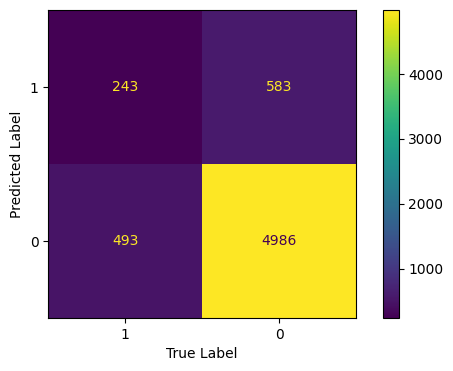

In [101]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["1","0"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [102]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

07-05-2025 21:28:10 Uploading figures


In [103]:
# Feature importance
pipe.get_params()["classifier"].feature_importances_

array([1.42662210e-02, 6.54897775e-03, 4.90289598e-03, 1.49463599e-02,
       5.34005539e-03, 6.15566370e-03, 9.07651477e-03, 5.21254752e-03,
       1.89836998e-02, 5.68593710e-03, 2.39400104e-03, 2.19513256e-02,
       2.02881834e-02, 8.62812526e-04, 1.63394628e-04, 1.05573151e-02,
       6.80225758e-03, 1.02871855e-02, 1.85743187e-02, 1.89945862e-02,
       1.32923775e-02, 1.67971110e-02, 0.00000000e+00, 2.86684156e-03,
       4.75017696e-02, 2.30557161e-03, 3.04835605e-02, 9.12876985e-03,
       7.40368359e-03, 1.17551204e-03, 1.87944872e-01, 8.17251961e-03,
       6.24866350e-02, 7.80843065e-02, 3.39943033e-03, 1.54245351e-02,
       3.67256964e-03, 8.76331918e-03, 1.69066910e-02, 9.48555375e-02,
       1.56858760e-01, 3.04813740e-02])

In [104]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_0',
 'education_4',
 'education_6',
 'education_9',
 'education_12',
 'education_16',
 'education_19',
 'default_unknown',
 'default_yes',
 'housing_unknown',
 'housing_yes',
 'loan_unknown',
 'loan_yes',
 'contact_telephone',
 'poutcome_nonexistent',
 'poutcome_success']

In [105]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['age',
 'month',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'pdays_contacted_status']

In [106]:
# merge all column names together
all_names = cat_names + num_names
all_names

['job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_0',
 'education_4',
 'education_6',
 'education_9',
 'education_12',
 'education_16',
 'education_19',
 'default_unknown',
 'default_yes',
 'housing_unknown',
 'housing_yes',
 'loan_unknown',
 'loan_yes',
 'contact_telephone',
 'poutcome_nonexistent',
 'poutcome_success',
 'age',
 'month',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'pdays_contacted_status']

In [107]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [108]:
# Visualize single plot
wandb.sklearn.plot_confusion_matrix(y_val, predict, [0,1])

In [109]:
# Catch up the class proportions between train and validation
wandb.sklearn.plot_class_proportions(y_train, y_val, [0,1])

In [110]:
# Plot the importance of columns
wandb.sklearn.plot_feature_importances(pipe.get_params()["classifier"],all_names)

In [111]:
# Plot a brief summary of the weighted avg results (recall, precision, f1, acc)
wandb.sklearn.plot_summary_metrics(pipe.get_params()["classifier"],
                                    full_pipeline_preprocessing.transform(x_train),
                                    y_train,
                                    full_pipeline_preprocessing.transform(x_val),
                                    y_val)

In [112]:
# ROC curve
predict_proba = pipe.predict_proba(x_val)
wandb.sklearn.plot_roc(y_val, predict_proba, [0,1])

In [113]:
x_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
       'euribor3m', 'nr_employed', 'pdays_contacted_status'],
      dtype='object')

In [114]:
x_train.head(1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
7234,25.0,admin,married,unknown,no,no,no,cellular,11.0,5.0,1.0,6.0,0.0,nonexistent,-3.4,92.649,-30.1,0.714,5017.5,0.0


In [115]:
# Recreate person1 from the first row of the CSV
person1 = pd.DataFrame([[25.0, 'admin', 'married', 'unknown', 'no', 'no', 'no', 'cellular', 11.0, 6,
                         1.0, 6.0, 0.0, 'nonexistent', -3.4, 92.649, -30.1, 0.714, 5017.5, 0.0]],
                       columns=x_train.columns)

# Prediction (assuming pipe is already fitted)
pred = pipe.predict(person1)
print(pred[0])

0


In [116]:
person2 = pd.DataFrame([[55.0, 'unemployed', 'married', 'basic 9y', 'no', 'yes', 'no', 'cellular', 10.0, 2,
                         1.0, 6.0, 0.0, 'nonexistent', -3.4, 92.431, -26.9, 0.728, 5017.5, 0.0]], columns=x_train.columns)
print(pipe.predict(person2))

[0]


In [117]:
# close the current run before to execute the next section
run.finish()

Acc,0.82934
F1,0.31114
Precision,0.29419
Recall,0.33016


## 1.6 Hyperparameter Tuning

In [118]:
# To see all parameters of a specific step of the pipeline
# pipe.named_steps['classifier'].get_params() #or
# pipe.named_steps['full_pipeline'].get_params()

In [119]:
# global seed
seed = 41

In [120]:
sweep_config = {
    "name": "decisiontree",  # <-- Naming the sweep
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "criterion": {
            "values": ["gini", "entropy"]
        },
        "splitter": {
            "values": ["random", "best"]
        },
        "model": {
            "values": [0, 1, 2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="Bank-Marketing")
logger.info("Sweep ID: {}".format(sweep_id))


07-05-2025 21:28:29 Sweep ID: g0ipig6b


Create sweep with ID: g0ipig6b
Sweep URL: https://wandb.ai/hangtn13-ssc-national-economics-university/Bank-Marketing/sweeps/g0ipig6b


In [121]:
def train():
    with wandb.init() as run:

        # The full pipeline 
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                    ("classifier",DecisionTreeClassifier())
                                    ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [122]:
wandb.agent(sweep_id, train, count=8)

wandb: Agent Starting Run: 2waiosyy with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


07-05-2025 21:28:37 Training
07-05-2025 21:28:38 Infering
07-05-2025 21:28:38 Evaluation metrics
07-05-2025 21:28:38 Accuracy: 0.8249008723235527
07-05-2025 21:28:38 Precision: 0.284037558685446
07-05-2025 21:28:38 Recall: 0.328804347826087
07-05-2025 21:28:38 F1: 0.3047858942065491


Accuracy,0.8249
F1,0.30479
Precision,0.28404
Recall,0.3288


wandb: Agent Starting Run: fr68q5zg with config:
wandb: 	criterion: entropy
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


07-05-2025 21:28:48 Training
07-05-2025 21:28:49 Infering
07-05-2025 21:28:49 Evaluation metrics
07-05-2025 21:28:49 Accuracy: 0.8363203806502776
07-05-2025 21:28:49 Precision: 0.31265822784810127
07-05-2025 21:28:49 Recall: 0.33559782608695654
07-05-2025 21:28:49 F1: 0.3237221494102228


Accuracy,0.83632
F1,0.32372
Precision,0.31266
Recall,0.3356


wandb: Agent Starting Run: dk9pukg2 with config:
wandb: 	criterion: gini
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


07-05-2025 21:29:00 Training
07-05-2025 21:29:00 Infering
07-05-2025 21:29:01 Evaluation metrics
07-05-2025 21:29:01 Accuracy: 0.8249008723235527
07-05-2025 21:29:01 Precision: 0.284037558685446
07-05-2025 21:29:01 Recall: 0.328804347826087
07-05-2025 21:29:01 F1: 0.3047858942065491


Accuracy,0.8249
F1,0.30479
Precision,0.28404
Recall,0.3288


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cfjnn9rg with config:
wandb: 	criterion: entropy
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: best


07-05-2025 21:29:19 Training
07-05-2025 21:29:20 Infering
07-05-2025 21:29:20 Evaluation metrics
07-05-2025 21:29:20 Accuracy: 0.8367961934972244
07-05-2025 21:29:20 Precision: 0.3138500635324015
07-05-2025 21:29:20 Recall: 0.33559782608695654
07-05-2025 21:29:20 F1: 0.32435981615233095


Accuracy,0.8368
F1,0.32436
Precision,0.31385
Recall,0.3356


wandb: Agent Starting Run: o5tgz4f4 with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: random


07-05-2025 21:29:32 Training
07-05-2025 21:29:33 Infering
07-05-2025 21:29:33 Evaluation metrics
07-05-2025 21:29:33 Accuracy: 0.8367961934972244
07-05-2025 21:29:33 Precision: 0.317103620474407
07-05-2025 21:29:33 Recall: 0.3451086956521739
07-05-2025 21:29:33 F1: 0.33051398828887435


Accuracy,0.8368
F1,0.33051
Precision,0.3171
Recall,0.34511


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pn1uns64 with config:
wandb: 	criterion: gini
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: best


07-05-2025 21:29:53 Training
07-05-2025 21:29:54 Infering
07-05-2025 21:29:54 Evaluation metrics
07-05-2025 21:29:54 Accuracy: 0.8301348136399683
07-05-2025 21:29:54 Precision: 0.300357568533969
07-05-2025 21:29:54 Recall: 0.3423913043478261
07-05-2025 21:29:54 F1: 0.31999999999999995


Accuracy,0.83013
F1,0.32
Precision,0.30036
Recall,0.34239


wandb: Agent Starting Run: 26zfo8vv with config:
wandb: 	criterion: entropy
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


07-05-2025 21:30:04 Training
07-05-2025 21:30:05 Infering
07-05-2025 21:30:05 Evaluation metrics
07-05-2025 21:30:05 Accuracy: 0.8363203806502776
07-05-2025 21:30:05 Precision: 0.31265822784810127
07-05-2025 21:30:05 Recall: 0.33559782608695654
07-05-2025 21:30:05 F1: 0.3237221494102228


Accuracy,0.83632
F1,0.32372
Precision,0.31266
Recall,0.3356


wandb: Agent Starting Run: 2lwwoxh0 with config:
wandb: 	criterion: entropy
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: best


07-05-2025 21:30:15 Training
07-05-2025 21:30:16 Infering
07-05-2025 21:30:16 Evaluation metrics
07-05-2025 21:30:16 Accuracy: 0.8367961934972244
07-05-2025 21:30:16 Precision: 0.3138500635324015
07-05-2025 21:30:16 Recall: 0.33559782608695654
07-05-2025 21:30:16 F1: 0.32435981615233095


Accuracy,0.8368
F1,0.32436
Precision,0.31385
Recall,0.3356


## 1.7 Configure and train the best model

In [123]:
#Note that a new run is yet synced to last sweep run 
# Just to check
run = wandb.init(project="Bank-Marketing")

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```1.5``` and ```1.6```. 

In [124]:
# initiate the wandb project
#run = wandb.init(project="risk_credit",job_type="train")

In [125]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})
pipe.set_params(**{"classifier__criterion": 'entropy'})
pipe.set_params(**{"classifier__splitter": 'random'})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

07-05-2025 21:30:20 Training


07-05-2025 21:30:21 Infering
07-05-2025 21:30:21 Evaluation metrics
07-05-2025 21:30:21 Accuracy: 0.8367961934972244
07-05-2025 21:30:21 Precision: 0.317103620474407
07-05-2025 21:30:21 Recall: 0.3451086956521739
07-05-2025 21:30:21 F1: 0.33051398828887435


In [126]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_0',
 'education_4',
 'education_6',
 'education_9',
 'education_12',
 'education_16',
 'education_19',
 'default_unknown',
 'default_yes',
 'housing_unknown',
 'housing_yes',
 'loan_unknown',
 'loan_yes',
 'contact_telephone',
 'poutcome_nonexistent',
 'poutcome_success']

In [127]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['age',
 'month',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'pdays_contacted_status']

In [128]:
# merge all column names together
all_names = cat_names + num_names
all_names

['job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_0',
 'education_4',
 'education_6',
 'education_9',
 'education_12',
 'education_16',
 'education_19',
 'default_unknown',
 'default_yes',
 'housing_unknown',
 'housing_yes',
 'loan_unknown',
 'loan_yes',
 'contact_telephone',
 'poutcome_nonexistent',
 'poutcome_success',
 'age',
 'month',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'pdays_contacted_status']

In [129]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

wandb: 
wandb: Plotting BestModel.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
c:\Users\Admin\miniconda3\envs\bankmkt\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


## 1.8 Export the best model

In [130]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [131]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

07-05-2025 21:30:31 Dumping the artifacts to disk


['target_encoder']

In [132]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Decision Tree model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

07-05-2025 21:30:31 Logging model artifact


<Artifact model_export>

In [133]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

07-05-2025 21:30:32 Logging target enconder artifact


<Artifact target_encoder>

In [134]:
run.finish()

Acc,0.8368
F1,0.33051
Precision,0.3171
Recall,0.34511
